### Import libraries

In [90]:
import os
from sound.sound_eval import eval_sound
import numpy as np
from matplotlib import pyplot as plt
import pydub
from time_series.anomaly_detection import polyreg_outliar_mse, lof
from time_series.smoothening_functions import power_smooth, llr_smooth, ewma_bias_corrected, kaiser_wind,derivative
from sklearn.metrics import precision_score, recall_score, average_precision_score

In [2]:
# Used to evaluate the linear regression:
def eval_linreg(arr, n, linreg):
    arr = np.array(arr).reshape((len(arr),))
    windows = []
    labels = []
    for i in range(len(arr)-n):
        windows.append(arr[i:i+n])
        labels.append(arr[i+n])
    return (linreg.predict(windows) - labels)**2

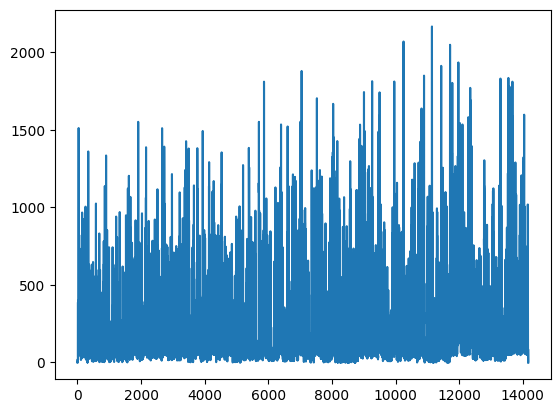

In [99]:
# Get the mp3 of the audio !!! NEEDS TO BE MONO !!!
a = pydub.AudioSegment.from_mp3("data/game4.mp3")
        
y = np.array(a.get_array_of_samples())
data_binr, data_rmsr, _ = eval_sound(y,a)
plt.plot(data_binr)
plt.show()

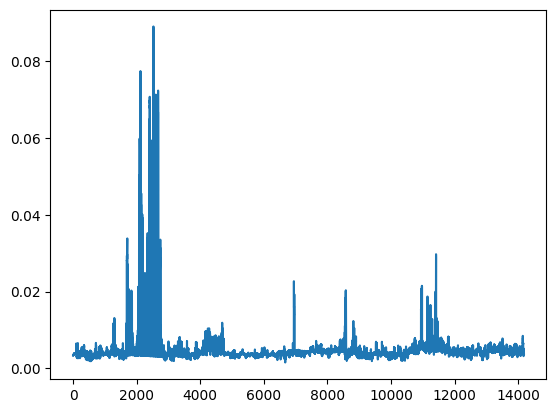

In [100]:
# Get the single frame analysis
singl_frm = np.loadtxt("data/arr.csv", delimiter = ",")
plt.plot(singl_frm)
plt.show()

In [13]:
# extract anomalous segments
def get_anomls(arr, signal, thr):
    segms = []
    
    
    print(thr)
    i = 0
    while i < len(arr):
        if arr[i] == 0:
            i+=1
            continue
        start = i
        while i < len(arr) and arr[i]>thr:
            i+=1
        
        
        
        segms.append([start, np.max(np.array(signal[i-180:i+180])), i])
        i+=1
    return segms

In [101]:
# labels in mmss format
labels = [[3204,3345],[2143,2231],[3350,3450],[3130,3220],[3300,3330],[1850, 1930]]
# video length total in seconds
video_legnth  = 60*39+23

In [102]:
# Evaluation
def get_ap(tot_length, res, labels,start = 0, ends = None):
    if not ends:
        ends = len(res)
    ground_truth = np.zeros((tot_length*6,))
    for l in labels:
        strt, end = l[0], l[1]
        strt = (strt%100)+60*int(strt/100)
        end = (end%100)+60*int(end/100)
        for i in range(strt*6-90,end*6+90):
            ground_truth[i] = 1
    
    
        
    return average_precision_score(ground_truth[start:ends], res)
def get_ap_at_k(tot_length, segms, labels):
    segms = reversed(segms)
    ground_truth = np.zeros((tot_length*6,))
    starts = np.zeros((tot_length*6,))
    ends = np.zeros((tot_length*6,))
    for l in labels:
        strt, end = l[0], l[1]
        strt = (strt%100)+60*int(strt/100)
        end = (end%100)+60*int(end/100)
        for i in range(strt*6-60,end*6+60):
            ground_truth[i] = 1
        starts[strt*6-10:strt*6+10] = 1
        ends[end*6-10: end*6+10] = 1
    count_starts = 0
    sums_starts = 0
    count_end = 0
    sums_end = 0
    count_coverage = 0
    sums_coverage = 0
    for i, s in enumerate(segms):
        if i > 6:
            break
        # Get starts:
        if np.sum(starts[s[0]-90:s[0]+60])>0:
            print("start ",i+1)
            count_starts += 1
            sums_starts += count_starts/(i+1)
        
        # Get ends:
        if np.sum(ends[s[-1]-60:s[-1]+90])>0:
            print("end ",i+1)
            count_end += 1
            sums_end += count_end/(i+1)
        # get coverage
        if np.mean(ground_truth[s[0]:s[-1]])>0.5:
            print("coverage ",i+1)
            count_coverage += 1
            sums_coverage += count_coverage/(i+1)
    
    return sums_starts/max(1,count_starts), sums_end/max(1,count_end), sums_coverage/max(1,count_coverage)
        


##### Perform LOF on audio data

14172


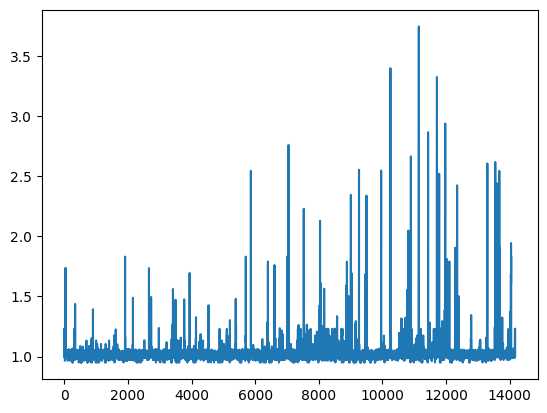

2.5437652929003254


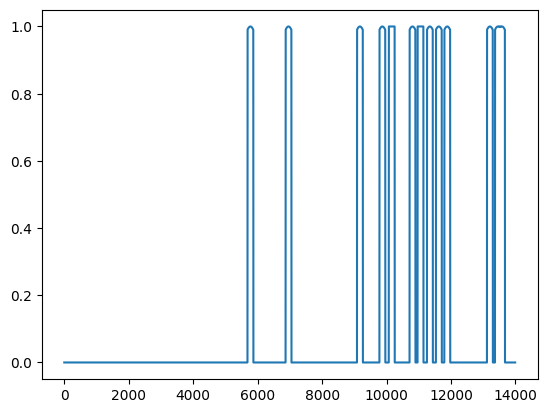

13993
0.5
12
15.794444444444444 16.294444444444444 2.5437652929003254
19.07777777777778 19.57777777777778 2.758889904159456
25.233333333333334 25.733333333333334 2.552973542109705
27.166666666666668 27.666666666666668 2.5468347093034516
27.97222222222222 28.477777777777778 3.397577387610038
29.76388888888889 30.26388888888889 2.664559271943369
30.45277777777778 30.955555555555556 3.7442306396031473
31.26388888888889 31.76388888888889 2.865075120267619
32.03611111111111 32.53611111111111 3.324085604055177
32.76111111111111 33.26111111111111 2.9373474329812366
36.43611111111111 36.93611111111111 2.605485449763195
37.12777777777778 37.980555555555554 2.617895846895836
15.794444444444444 16.294444444444444 2.5437652929003254
27.166666666666668 27.666666666666668 2.5468347093034516
25.233333333333334 25.733333333333334 2.552973542109705
36.43611111111111 36.93611111111111 2.605485449763195
37.12777777777778 37.980555555555554 2.617895846895836
29.76388888888889 30.26388888888889 2.664559271

In [103]:

interm = np.array(data_binr)
r = 480
interm  = lof(interm, r )
signal  = interm

plt.plot(interm)
plt.show()
print(np.quantile(interm, 0.999))
interm = interm >= np.quantile(interm, 0.999) + 0
interm  = kaiser_wind(interm, 180, 0.2 )
interm[interm>1] = 1
plt.plot(interm)
plt.show()

print(len(interm))
segms = get_anomls(interm, signal, 0.5)
print(len(segms))
# segm_means = [np.mean(np.array(i)) for i in segms]
# print(segm_means)
for s in segms:
    # s[0]-=r/2
    # s[-1]+=180
    print(s[0]/360, s[-1]/360, s[1])
segms.sort(key=lambda x: x[1])
print("============")

for s in segms:
    # s[0]-=180
    # s[-1]+=180
    print(s[0]/360, s[-1]/360, s[1])
print("AP:", get_ap(video_legnth, interm, labels))
print("START@6, END@6, COVERAGE@6", get_ap_at_k(video_legnth, segms, labels))

##### Get LOF of Single frame reconstruction

14181


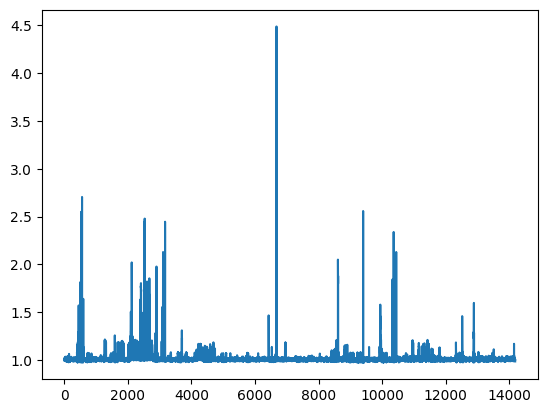

1.5960340201379022


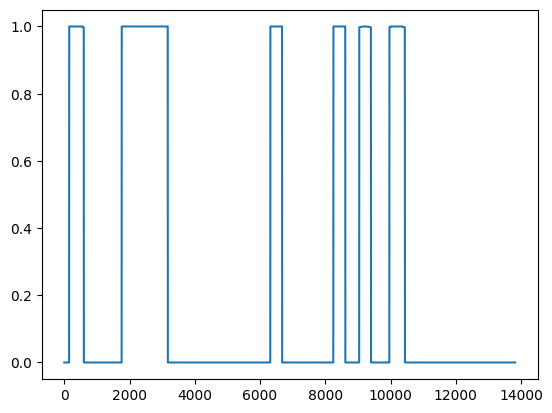

0.5
13822
6
0.1638888888888889 1.6611111111111112 2.7045673918896695
4.636111111111111 8.811111111111112 2.445391641263754
17.291666666666668 18.544444444444444 4.48881584204
22.658333333333335 23.925 2.0488530936951537
24.86111111111111 26.11111111111111 2.5574950816912425
27.427777777777777 29.0 2.3380893035348036
22.658333333333335 23.925 2.0488530936951537
27.427777777777777 29.0 2.3380893035348036
4.636111111111111 8.811111111111112 2.445391641263754
24.86111111111111 26.11111111111111 2.5574950816912425
0.1638888888888889 1.6611111111111112 2.7045673918896695
17.291666666666668 18.544444444444444 4.48881584204
AP: 0.1594524748437775
(0.0, 0.0, 0.0)


In [104]:
# segms = SWIDE_ours(kaiser_wind(lof(np.array(data_binr), 360),180,4), 5)
print(len(singl_frm))
interm = np.array(singl_frm)
r = 240
interm  = lof(interm, r )
signal  = interm

plt.plot(interm)
plt.show()
print( np.quantile(interm, 0.995))
interm = interm > np.quantile(interm, 0.995) + 0
interm  = kaiser_wind(interm, 360, 0.1 )
interm[interm>1] = 1

plt.plot(interm)
plt.show()
segms = get_anomls(interm, signal, 0.5)
print(len(interm))
print(len(segms))
# segm_means = [np.mean(np.array(i)) for i in segms]
# print(segm_means)
for s in segms:
    s[0]-=90
    # s[-1]+=90
    print(s[0]/360, s[-1]/360, s[1])
segms.sort(key=lambda x: x[1])


print("============")
for s in segms:
    # s[0]-=180
    # s[-1]+=180
    print(s[0]/360, s[-1]/360, s[1])
print("AP:", get_ap(video_legnth, interm, labels, start = 90, ends = len(interm)+90))
print("START@6, END@6, COVERAGE@6",get_ap_at_k(video_legnth, segms, labels))

### Regressor on audi data

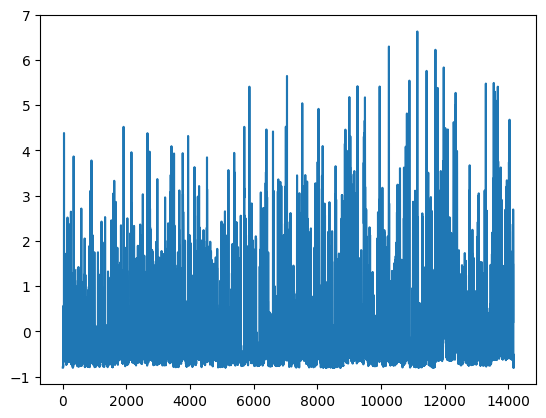

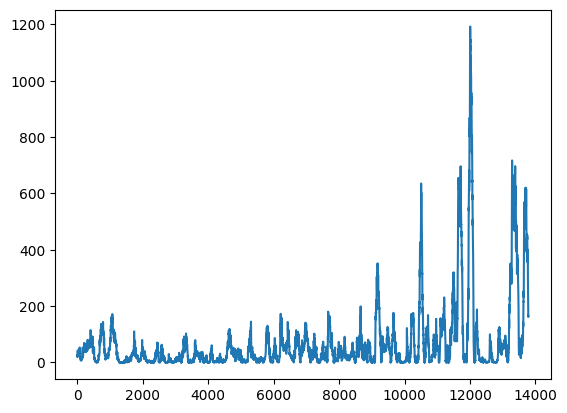

328.1444829216667


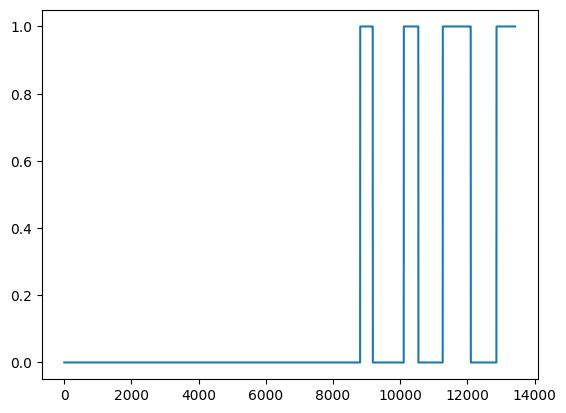

0.5
4
25.466666666666665 26.508333333333333 1.0821325046974402
29.072222222222223 30.27777777777778 2.128633945715752
32.294444444444444 34.611111111111114 1.027994998701481
36.736111111111114 38.28888888888889 1.1103759737547023
32.294444444444444 34.611111111111114 1.027994998701481
25.466666666666665 26.508333333333333 1.0821325046974402
36.736111111111114 38.28888888888889 1.1103759737547023
29.072222222222223 30.27777777777778 2.128633945715752
AP: 0.24633378998843625
start  4
end  4
coverage  4
(0.25, 0.25, 0.25)


In [105]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
r = 180
d_interm = sc.fit_transform(X  =np.array(data_binr).reshape(-1,1), y = None)
# d_interm = np.log(np.array(data_binr))
# d_interm = data_binr
plt.plot(d_interm)
plt.show()
unsup_linreg = polyreg_outliar_mse([d_interm.reshape(-1,)],r)
interm = eval_linreg(kaiser_wind(d_interm.reshape(-1,), r+30, 2), r, unsup_linreg)
plt.plot(interm)
plt.show()
print( np.quantile(interm, 0.95))
interm = interm > np.quantile(interm, 0.95) + 0
interm  = kaiser_wind(interm, 360, 0.1 )
interm[interm>1] = 1
plt.plot(interm)
plt.show()
segms = get_anomls(interm, signal, 0.5)
print(len(segms))
# segm_means = [np.mean(np.array(i)) for i in segms]
# print(segm_means)
for s in segms:
    # s[0]-=r/2
    s[0]+=2*r
    s[-1]+=2*r
    print(s[0]/360, s[-1]/360, s[1])
segms.sort(key=lambda x: x[1])
print("============")


for s in segms:
    # s[0]-=180
    # s[-1]+=180
    print(s[0]/360, s[-1]/360, s[1])
print("AP:", get_ap(video_legnth, interm, labels, start = 2*r, ends = len(interm)+2*r ))
print("START@6, END@6, COVERAGE@6",get_ap_at_k(video_legnth, segms, labels))